Importamos las herramientas con que vamos a trabajar

In [141]:
import numpy as np 
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import chardet

Vamos a relevar la codificación que tiene el archivo

In [142]:
def get_encoding_type(csv_path):
    rawdata = open(csv_path, 'rb').read()
    result = chardet.detect(rawdata)
    return result.get('encoding')


In [143]:
data_location = "../data/properati.csv"
data_orig = pd.read_csv(data_location, sep = ",", encoding = 'utf-8')
print(data_orig.shape)
data_orig.dtypes

(121220, 26)


Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: objec

## Elimino registros duplicados

Veamos si existen registros duplicados en el `DataFrame` data considerando sólo las columnas **"property_type"**, **"place_name"**, **"price"**, **"currency"**, **"surface_total_in_m2"**, **"surface_covered_in_m2"**, marcando como no duplicado la primera ocurrencia de un registro.

NOTA: Se desprecia la columna **"description"**, siendo que aún se encuentran duplicados al tener en cuenta dicha olumna.

In [144]:
# subset que utilizaré para eliminar registros duplicados
subset = ["property_type","place_name","price","currency","surface_total_in_m2","surface_covered_in_m2"]
mask_duplicated = data_orig.duplicated(subset, keep = 'first')

# subset considerando "description":
subset = ["property_type","place_name","price","currency","surface_total_in_m2","surface_covered_in_m2","description"]
mask_duplicated_with_description = data_orig.duplicated(subset, keep = 'first')


print('Cantidad de registros duplicados: '+str(mask_duplicated.sum()))
print('Cantidad de registros duplicados considerando" description": '+str(mask_duplicated_with_description.sum()))

duplicated_records = data_orig.loc[mask_duplicated]
duplicated_records.head(3).sort_values(by = 'place_name')

Cantidad de registros duplicados: 22432
Cantidad de registros duplicados considerando" description": 6555


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
84,84,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.9327656,-60.6533854",-32.932766,...,55.0,NaN,NaN,NaN,2.0,NaN,http://www.properati.com.ar/15bz0_ve...,Departamento en PB con cocina comedo...,2 Dormitorios. Güemes al 2400,https://thumbs4.properati.com/3/p47w...
101,101,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.9359588621,-60.6691426017",-32.935959,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15d1n_ve...,Tucuman 3476Edificio PB y 4 pisos po...,Rosario - Tucuman 3400 - Venta Dptos...,https://thumbs4.properati.com/1/2fJF...
102,102,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.9359588621,-60.6691426017",-32.935959,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15d1o_ve...,Tucuman 3476Edificio PB y 4 pisos po...,Rosario - Tucuman 3400 - Venta Dptos...,https://thumbs4.properati.com/3/Ugx8...


In [145]:
data_nodup = data_orig.drop_duplicates(subset, keep = "first")
print(data_orig.shape)
print(data_nodup.shape)

# Vemos que no quedan registros duplicados para el subset definido 
#dup_mask = data_nodup.duplicated(subset, keep = "first")
#any(dup_mask)

(121220, 26)
(114665, 26)


## Análisis de la información - Desestimación de datos

Veamos la cantidad de nulos que hay en mi `DataFrame` original

In [146]:
data_orig.isnull().sum()/data_orig.shape[0]

Unnamed: 0                    0.000000
operation                     0.000000
property_type                 0.000000
place_name                    0.000190
place_with_parent_names       0.000000
country_name                  0.000000
state_name                    0.000000
geonames_id                   0.154405
lat-lon                       0.425260
lat                           0.425260
lon                           0.425260
price                         0.168372
currency                      0.168380
price_aprox_local_currency    0.168372
price_aprox_usd               0.168372
surface_total_in_m2           0.324435
surface_covered_in_m2         0.164222
price_usd_per_m2              0.433947
price_per_m2                  0.276869
floor                         0.934837
rooms                         0.609058
expenses                      0.882346
properati_url                 0.000000
description                   0.000016
title                         0.000000
image_thumbnail          

In [147]:
print(data_nodup.shape)
data_nodup.head(3)

(114665, 26)


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_ve...,2 AMBIENTES TIPO CASA PLANTA BAJA PO...,2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluU...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La...,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_ve...,Venta de departamento en décimo piso...,VENTA Depto 2 dorm. a estrenar 7 e/ ...,https://thumbs4.properati.com/7/ikpV...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_ve...,2 AMBIENTES 3ER PISO LATERAL LIVING ...,2 AMB 3ER PISO CON ASCENSOR APTO CRE...,https://thumbs4.properati.com/5/SXKr...


## Análisis para eliminar registros 

Veamos los registros que no que no tienen moneda en AR o US$

In [148]:
data_nodup.currency.value_counts()

USD    85035
ARS    12541
PEN        2
UYU        1
Name: currency, dtype: int64

Veo qué pasa con **PEN**.
Se dropea?

In [149]:
mask_PEN = data_nodup.currency == 'PEN'
print('Precios de PEN:\n'+str(data_nodup.loc[mask_PEN].price))
data_nodup.loc[mask_PEN]

Precios de PEN:
50387    380000.0
50388    950000.0
Name: price, dtype: float64


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
50387,50387,sell,apartment,Capital Federal,|Argentina|Capital Federal|,Argentina,Capital Federal,3433955.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/19e8z_ve...,Ref.: 55:PREVENTA ::: OPORTUNIDAD ::...,DUPLEX A LA VENTA | Liniers 1200 | T...,https://thumbs4.properati.com/9/N_Qr...
50388,50388,sell,apartment,Capital Federal,|Argentina|Capital Federal|,Argentina,Capital Federal,3433955.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/19e90_ve...,Ref.: 56Duplex en venta de 1 dormito...,DUPLEX A LA VENTA | Liniers 1200 | T...,https://thumbs4.properati.com/8/_cBX...


Veo qué pasa con **UYU**.
Se dropea?

In [150]:
mask_UYU = data_nodup.currency == 'UYU'
print('Precios de UYU:\n'+str(data_nodup.loc[mask_UYU].price))
data_nodup.loc[mask_UYU]

Precios de UYU:
107390    650000000.0
Name: price, dtype: float64


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
107390,107390,sell,house,San Roque,|Argentina|Mendoza|San Roque|,Argentina,Mendoza,3836586.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1by0s_ve...,"Casa con Calefacción central, Mendoz...",Casa - San Vicente,https://thumbs4.properati.com/2/pA0R...


Elimino los registros que no tienen moneda en AR o US$

In [151]:
mask_AR_US = np.logical_or(data_nodup.currency == 'UYU', data_nodup.currency == 'PEN') 
print('Cantidad de elementos a eliminar: ', str(mask_AR_US.sum()))

# Identifico los índices que voy a eliminar
inds = data_nodup.loc[mask_AR_US].index
inds

Cantidad de elementos a eliminar:  3


Int64Index([50387, 50388, 107390], dtype='int64')

In [152]:
data_nodup_dropped = data_nodup.drop(index = inds)
print("Filas en Registros limpios: "+str(data_nodup_dropped.shape[0]))
print("Filas en Registros anterior: "+str(data_nodup.shape[0]))
data_nodup_dropped.head()

Filas en Registros limpios: 114662
Filas en Registros anterior: 114665


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_ve...,2 AMBIENTES TIPO CASA PLANTA BAJA PO...,2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluU...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La...,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_ve...,Venta de departamento en décimo piso...,VENTA Depto 2 dorm. a estrenar 7 e/ ...,https://thumbs4.properati.com/7/ikpV...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_ve...,2 AMBIENTES 3ER PISO LATERAL LIVING ...,2 AMB 3ER PISO CON ASCENSOR APTO CRE...,https://thumbs4.properati.com/5/SXKr...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_ve...,PH 3 ambientes con patio. Hay 3 dept...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIf...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlánt...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_ve...,DEPARTAMENTO CON FANTÁSTICA ILUMINAC...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CEN...,https://thumbs4.properati.com/5/xrRq...


Armo un `DataFrama` **data** quedándome con las columnas de interés.

In [153]:
subset = ['Unnamed: 0','operation','country_name','geonames_id','lat-lon','lat','lon','floor','expenses','properati_url','image_thumbnail']

data = data_nodup_dropped.drop(subset, axis = 1)
print(data.shape)
data.sample(3)

(114662, 15)


,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title
28089,apartment,Balvanera,|Argentina|Capital Federal|Balvanera|,Capital Federal,120000.0,USD,2117340.0,120000.0,NaN,47.0,NaN,2553.191489,3.0,Corredor Responsable: Hernan Perrone...,DEPTO DE CATEGORIA 3 AMBIENTES
98848,house,Lanús,|Argentina|Bs.As. G.B.A. Zona Sur|La...,Bs.As. G.B.A. Zona Sur,320000.0,USD,5646240.0,320000.0,680.0,525.0,470.588235,609.523810,NaN,Casa para dos familias sobre doble l...,Casa - Lanús Oeste
28122,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Santa Fe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Corredor Responsable: CRISTIAN ASTOL...,DEPTO 3 DORMITORIOS CON COCHERA PISO...


## Análisis de precios

Veamos cuestiones referido a los precios en AR o US$.

Lo primero para analizar es la tasa de conversión entre pesos y dólares, la cual viene dada por el factor de conversión 17.6445, no importa si el precio se define en $AR o USD. Con este argumento podrían eliminar algunos datos.

In [154]:
# tasa de conversión
serie_price_aprox_local_currency = data.price_aprox_local_currency
serie_price_aprox_usd = data.price_aprox_usd

tasa_conversion = (serie_price_aprox_local_currency/serie_price_aprox_usd).round(4)
tasa_conversion.value_counts()

17.6445    97576
dtype: int64

In [155]:
# Me fijo inconsistencia en los precios en AR y US$
mask_prices = data.price_aprox_usd >= data.price_aprox_local_currency
print("Cantidad de inconsistencias: ", mask_prices.sum())
data.loc[mask_prices]

Cantidad de inconsistencias:  1


,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title
9761,house,Córdoba,|Argentina|Córdoba|,Córdoba,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,3.0,Casa en Venta de 2 dorm. en Armenia,SE VENDE CASA EN EL BARRIO EL LIMONAR


In [156]:
#Veo si hay algún dato rescatable
print(data.loc[mask_prices].title)
print(data.loc[mask_prices].description)

9761    SE VENDE CASA EN EL BARRIO EL LIMONAR
Name: title, dtype: object
9761    Casa en Venta de 2 dorm. en Armenia
Name: description, dtype: object


Dado que este registro tiene los datos de interés en **NaN** y no se puede extraer información de otros registros, decido eliminarlo.

In [157]:
ind_prices = data.loc[mask_prices].index

# Elimino el registro
data = data.drop(index = ind_prices)
data.shape

(114661, 15)

Veo si **NO** tiene definido el precio pero **SÍ** el precio/m2.

Vemos que **NO** se da el caso.

In [158]:
mask_prices = np.logical_and(data.price.isnull(), data.price_usd_per_m2.notnull())
mask_prices.sum()

0

In [159]:
data.head(2)

,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.0,NaN,2 AMBIENTES TIPO CASA PLANTA BAJA PO...,2 AMB TIPO CASA SIN EXPENSAS EN PB
1,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La...,Bs.As. G.B.A. Zona Sur,150000.0,USD,2646675.0,150000.0,NaN,NaN,NaN,NaN,NaN,Venta de departamento en décimo piso...,VENTA Depto 2 dorm. a estrenar 7 e/ ...


In [160]:
# Evalúo para USD
mask_usd = data.currency == 'USD'
print(mask_usd.sum())
mask_prices_usd = data.loc[mask_usd].price.round(2) == data.loc[mask_usd].price_aprox_usd.round(2)
print(mask_prices_usd.sum())

85035
85035


Vemos que coincide la columna **price** con **price_aprox_usd** cuando **currency** es USD.

Veamos qué sucede cuando **price** es ARS:

In [161]:
# Evalúo para ARS
mask_ars = data.currency == 'ARS'
print(mask_ars.sum())
mask_prices_ars = data.loc[mask_ars].price.round(2) == data.loc[mask_ars].price_aprox_local_currency.round(2)
print(mask_prices_ars.sum())
data.loc[mask_ars].head()

12541
0


,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title
9,house,Rosario,|Argentina|Santa Fe|Rosario|,Santa Fe,460000.0,ARS,455201.45,25798.49,NaN,NaN,NaN,NaN,NaN,MEDNOZA AL 7600A UNA CUADRA DE CALLE...,WHITE 7637 - 2 DORMITORIOS CON PATIO...
32,apartment,Córdoba,|Argentina|Córdoba|Córdoba|,Córdoba,550000.0,ARS,544262.59,30846.02,50.0,50.0,616.920400,11000.000000,3.0,"EN VENTA, departamento ubicado en ba...",Departamento apto crédito! Barrio Pu...
37,house,Malagueño,|Argentina|Córdoba|Malagueño|,Córdoba,1250000.0,ARS,1236960.43,70104.59,75.0,75.0,934.727867,16666.666667,NaN,Nuevos ingreso:-VENTA-Villa San Nico...,Casa Venta Villa San Nicolas
78,house,Posadas,|Argentina|Misiones|Posadas|,Misiones,5500000.0,ARS,5442626.35,308460.22,261.0,18615.0,1181.839923,295.460650,5.0,"S/AVDA COSTANERA , NUEVA ZONA GA...",Oportunidad! Casa zona Bahía el Brete
97,apartment,San Telmo,|Argentina|Capital Federal|San Telmo|,Capital Federal,1423800.0,ARS,1408947.37,79851.93,NaN,NaN,NaN,NaN,1.0,Torre de 15 pisos con amenities ubic...,VIVÍ CERCA DE TODO Av. 9 de Julio


Cómo vemos que **price** en ARS no cinciden, veamos si tienen relación con **price_aprox_usd**:

In [162]:
# tasa de conversión
serie_price_ARS = data[mask_ars].price
serie_price_aprox_usd = data[mask_ars].price_aprox_usd

tasa_conversion = (serie_price_ARS/serie_price_aprox_usd).round(4)
tasa_conversion.value_counts()

17.8305    12217
17.1430      255
17.6340       52
17.7980        6
17.2040        4
17.5025        3
17.4265        1
17.4040        1
17.4670        1
17.4050        1
dtype: int64

Como vemos que predomina la tasa de cambio de 17.8305 entre el **price** en ARS y el **price_aprox_usd**, vamos a utilizar esta tasa para redefinir los precios en US$.

Vamos a definir una nueva columna **"price_USD"** y va a contener:
- Los valores de price cuando currency sea USD
- Los valores de price modificados por la tasa de cambio de 17.8305 cuando currency sea ARS

In [163]:
data.loc[mask_usd,"price_USD"] = (data.loc[mask_usd,"price"]).round(0)
data.loc[mask_ars,"price_USD"] = (data.loc[mask_ars,"price"]/17.8305).round(0)

print("Cantidad de nulls en columna price_USD: ",data["price_USD"].isnull().sum())
print("Cantidad de nulls en columna price: ",data["price_USD"].isnull().sum())

Cantidad de nulls en columna price_USD:  17085
Cantidad de nulls en columna price:  17085


A partir de aquí sabemos que podemos eliminar las columnas **price**, **currency**, **price_aprox_local_currency**, **price_aprox_usd**, pero vamos a dejarlo para después porque podemos llegar a necesitarlas en el análisis de las superficies y precio/superficie.

## INICIO DE REGEX

Quiero ver si en los registros en que "price" es null puedo extraer los precios de "description".

**NO FUNCIONA**.

In [164]:
mask_nulls_prices = data["price"].isnull()
data.loc[mask_nulls_prices,'price']

5        NaN
20       NaN
41       NaN
62       NaN
67       NaN
          ..
121210   NaN
121211   NaN
121212   NaN
121213   NaN
121214   NaN
Name: price, Length: 17085, dtype: float64

In [165]:
import re
price_pattern = 'precio'
price_regex = re.compile(price_pattern)

precio_in_description = data.loc[mask_nulls_prices].description.apply(lambda x: x if x is np.NaN else price_regex.search(x))
mask_precio_in_description_notnull = precio_in_description.notnull()
print(precio_in_description)
print(mask_precio_in_description_notnull)
print(mask_precio_in_description_notnull.sum())

resultado = precio_in_description.loc[mask_precio_in_description_notnull].apply(lambda x: x.group(0))
resultado

5         None
20        None
41        None
62        None
67        None
          ... 
121210    None
121211    None
121212    None
121213    None
121214    None
Name: description, Length: 17085, dtype: object
5         False
20        False
41        False
62        False
67        False
          ...  
121210    False
121211    False
121212    False
121213    False
121214    False
Name: description, Length: 17085, dtype: bool
1311


124       precio
125       precio
126       precio
263       precio
264       precio
           ...  
121032    precio
121036    precio
121049    precio
121050    precio
121110    precio
Name: description, Length: 1311, dtype: object

In [166]:
data.iloc[264].description

'CODIGO:  ubicado en: Ricardo Balbin DR. 4300 -  Publicado por: LA KASA FELIZ PROP. Y SERVICIOS. El precio es de USD 181000 null. Descripción  A ESTRENAR - POSESION y ESCRITURA DENTRO DE LOS 60 DIAS DEPARTAMENTO AL CONTRAFRENTE - SUPERFICIE TOTAL: 71,88 m2. - DE 3 AMBIENTES: LIVING-COMNEDOR: 7,60X3 CON SALIDA A BALCON  2 DORMITORIOS CON PLACARDS CON FRENTE ESPEJADO y CON INTERIORES COMPLETOS: (3,10X2,70 CON SALIDA A BALCON) (3,04X2,80) 1 BAÑO TOIILETTE COCINA CON LAVADERO INCORPORADO. CALEFACCION POR LOZA RADIANTE INDIVIDUAL POR CABLE, MARCA EUROCABLE, TERMOSTATO POR AMBIENTE. AGUA CALIENTE CENTRAL. PREINSTALACION ELECTRICA PARA EQUIPOS TIPO SPLITS . INSTALACION DE TELEFONICA: LAS UNIDADES SE ENTREGAN CABLEADAS HASTA LA PRIMER BOCA y CUENTAN CON CANALIZACIONES VACIAS. CANALIZACIONES y BOCAS VACIAS PARA CONEXION DE TV DETALLES DEL EDIFICIO: HALL CON MARMOL y REVESTIMIENTO EN WENGUE. 2 ASCENSORES DE PRIMERA MARCA (UNO PARA 14 PERSONAS). AGUA CALIENTE CENTRAL, CON TRES TERMOTANQUES MARCA 

In [167]:
data.iloc[264]

property_type                                               apartment
place_name                                                   Saavedra
place_with_parent_names          |Argentina|Capital Federal|Saavedra|
state_name                                            Capital Federal
price                                                          181000
currency                                                          USD
price_aprox_local_currency                                3.19365e+06
price_aprox_usd                                                181000
surface_total_in_m2                                                71
surface_covered_in_m2                                              67
price_usd_per_m2                                               2549.3
price_per_m2                                                  2701.49
rooms                                                             NaN
description                   CODIGO:  ubicado en: Ricardo Balbin ...
title               

## FIN DE REGEX

## Análisis de Superficies

Veamos cuestiones relacionadas a los campos "surface_total_in_m2" y "surface_covered_in_m2".
VAmos a tratar de limpiar, emprolijar y reconstruir estos campos.

In [168]:
data.isnull().sum()/data.shape[0]

property_type                 0.000000
place_name                    0.000201
place_with_parent_names       0.000000
state_name                    0.000000
price                         0.149004
currency                      0.149004
price_aprox_local_currency    0.149004
price_aprox_usd               0.149004
surface_total_in_m2           0.331141
surface_covered_in_m2         0.161868
price_usd_per_m2              0.423553
price_per_m2                  0.260507
rooms                         0.603614
description                   0.000017
title                         0.000000
price_USD                     0.149004
dtype: float64

In [169]:
# Acá me aseguro que ninguno de los dos campos tengan nulls:
mask_size_right_surfaces = data.surface_total_in_m2 >= data.surface_covered_in_m2
print('Cantidad de registros coherentes: ' + str(mask_size_right_surfaces.sum()))
data.loc[mask_size_right_surfaces].head(2)

Cantidad de registros coherentes: 68824


,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,price_USD
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,2 AMBIENTES TIPO CASA PLANTA BAJA PO...,2 AMB TIPO CASA SIN EXPENSAS EN PB,62000.0
2,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,72000.0,USD,1270404.0,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,2 AMBIENTES 3ER PISO LATERAL LIVING ...,2 AMB 3ER PISO CON ASCENSOR APTO CRE...,72000.0


In [170]:
# Agrego los datos verificados en nuevas columnas:
data.loc[mask_size_right_surfaces,'superficie_TOTAL'] = data.loc[mask_size_right_surfaces,'surface_total_in_m2']
data.loc[mask_size_right_surfaces,'superficie_CUBIERTA'] = data.loc[mask_size_right_surfaces,'surface_covered_in_m2']
data.head(1)

,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,price_USD,superficie_TOTAL,superficie_CUBIERTA
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.0,NaN,2 AMBIENTES TIPO CASA PLANTA BAJA PO...,2 AMB TIPO CASA SIN EXPENSAS EN PB,62000.0,55.0,40.0


In [171]:
# Vamos a calcular la media y desvío estándar de la diferencia entre ambas sups:
resta_sups_right = (data.loc[mask_size_right_surfaces].surface_total_in_m2 - data.loc[mask_size_right_surfaces].surface_covered_in_m2)
mean_surfaces_right = resta_sups_right.mean().round(2)
stdv_surfaces_right = resta_sups_right.std().round(2)

print('MEAN de la diferencia de superficies: '+str(mean_surfaces_right))
print('STD de la diferencia de superficies: '+str(stdv_surfaces_right))

MEAN de la diferencia de superficies: 113.73
STD de la diferencia de superficies: 1546.88


In [172]:
#from bokeh.plotting import figure, output_notebook, show
#from bokeh.models import HoverTool

#p = figure(plot_width=600, plot_height=400)
#p.circle(x=resta_sups_right.index, y=resta_sups_right.values, size=8)

#hover = HoverTool(tooltips=[("index", "$index"), ("(x,y)", "($x, $y)")])

#p.add_tools(hover)
#output_notebook()
#show(p)

In [173]:
#data.loc[mask_size_right_surfaces].iloc[5975]

Veamos cuando solo tenemos una de las dos superficies definidas:

In [174]:
mask_surface_total_in_m2_nulls = data.surface_total_in_m2.isnull()
mask_surface_covered_in_m2_nulls = data.surface_covered_in_m2.isnull()

In [175]:
# Tengo TOTAL pero no tengo CUBIERTA
mask_surface_total = np.logical_and(np.logical_not(mask_surface_total_in_m2_nulls),mask_surface_covered_in_m2_nulls)
print('Cantidad de casos: ' + str(mask_surface_total.sum()))
data.loc[mask_surface_total,'superficie_TOTAL'] = data.loc[mask_surface_total,'surface_total_in_m2']
data.loc[mask_surface_total].head(1)

Cantidad de casos: 6776


,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,price_USD,superficie_TOTAL,superficie_CUBIERTA
5,house,Gualeguaychú,|Argentina|Entre Ríos|Gualeguaychú|,Entre Ríos,NaN,NaN,NaN,NaN,53.0,NaN,NaN,NaN,NaN,"Casa en el perímetro del barrio 338,...",Casa Barrio 338. Sobre calle 3 de ca...,NaN,53.0,NaN


In [176]:
# Tengo CUBIERTA pero no tengo TOTAL
mask_surface_covered = np.logical_and(mask_surface_total_in_m2_nulls,np.logical_not(mask_surface_covered_in_m2_nulls))
print('Cantidad de casos: ' + str(mask_surface_covered.sum()))
data.loc[mask_surface_covered,'superficie_CUBIERTA'] = data.loc[mask_surface_covered,'surface_covered_in_m2']
data.loc[mask_surface_covered].head(1)

Cantidad de casos: 26185


,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,price_USD,superficie_TOTAL,superficie_CUBIERTA
68,apartment,Mar del Plata,|Argentina|Buenos Aires Costa Atlánt...,Buenos Aires Costa Atlántica,235000.0,USD,4146457.5,235000.0,NaN,72.0,NaN,3263.888889,2.0,"Cocina integrada con barra , horno ...",EXCELENTE DEPARTAMENTO CON VISTA AL ...,235000.0,NaN,72.0


Veamos qué pasa con los casos donde la sup cubierta es mayor que sup total:

In [177]:
mask_size_surfaces = data.surface_total_in_m2 < data.surface_covered_in_m2
print('Cantidad de inconsistencias en superficie: ' + str(mask_size_surfaces.sum()))
data.loc[mask_size_surfaces].head(2)

Cantidad de inconsistencias en superficie: 1092


,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,price_USD,superficie_TOTAL,superficie_CUBIERTA
78,house,Posadas,|Argentina|Misiones|Posadas|,Misiones,5500000.0,ARS,5442626.35,308460.22,261.0,18615.0,1181.839923,295.460650,5.0,"S/AVDA COSTANERA , NUEVA ZONA GA...",Oportunidad! Casa zona Bahía el Brete,308460.0,NaN,NaN
177,apartment,Villa Carlos Paz,|Argentina|Córdoba|Villa Carlos Paz|,Córdoba,470000.0,USD,8292915.00,470000.00,420.0,450.0,1119.047619,1044.444444,9.0,"CASA PRINCIPAL QUE CONSTA DE 3 DORM,...",SE VENDE VIVIENDA+LOCALES COMERCIALE...,470000.0,NaN,NaN


In [178]:
# Vamos a calcular la media y desvío estándar de la diferencia entre ambas sups:
resta_sups_wrong = (data.loc[mask_size_surfaces].surface_covered_in_m2 - data.loc[mask_size_surfaces].surface_total_in_m2)
mean_surfaces_wrong = resta_sups_wrong.mean().round(2)
stdv_surfaces_wrong = resta_sups_wrong.std().round(2)

print('MEAN de la diferencia de superficies: '+str(mean_surfaces_wrong))
print('STD de la diferencia de superficies: '+str(stdv_surfaces_wrong))

MEAN de la diferencia de superficies: 321.76
STD de la diferencia de superficies: 2478.97


In [179]:
resta_sups_wrong.shape[0]

1092

In [180]:
mask_resta_sups_wrong_acceptable = resta_sups_wrong < mean_surfaces_right
mask_resta_sups_wrong_acceptable.shape[0]

1092

Como la mayoría de la diferencia de estas superficies está por debajo de la media de las que asumo que están bien, entonces invierto los valores y los cargo en las nuevas columnas.

In [181]:
# NO ME FUNCIONA!!!
# me quedan en NaN las nuevas columnas

# Agrego los datos verificados en nuevas columnas:
#data.loc[mask_size_surfaces,'superficie_TOTAL'].loc[mask_resta_sups_wrong_acceptable] = data.loc[mask_size_surfaces,'surface_covered_in_m2'].loc[mask_resta_sups_wrong_acceptable]
#data.loc[mask_size_surfaces.loc[mask_resta_sups_wrong_acceptable],'superficie_CUBIERTA'] = data.loc[mask_size_surfaces,'surface_total_in_m2']
data.loc[mask_size_surfaces].loc[mask_resta_sups_wrong_acceptable].head(1)
#mask_size_surfaces

,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,price_USD,superficie_TOTAL,superficie_CUBIERTA
177,apartment,Villa Carlos Paz,|Argentina|Córdoba|Villa Carlos Paz|,Córdoba,470000.0,USD,8292915.0,470000.0,420.0,450.0,1119.047619,1044.444444,9.0,"CASA PRINCIPAL QUE CONSTA DE 3 DORM,...",SE VENDE VIVIENDA+LOCALES COMERCIALE...,470000.0,NaN,NaN


Vemos que la media y std son bastante mayores a los valores consistentes. 

Vamos a hacer algunos gráficos para identificar visualmente qué indices de mi `Serie` **diferencia_surface** tiene diferencias entre superficie "grandes".

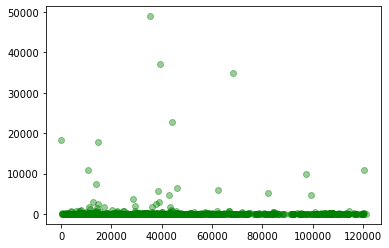

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure()
# creo los axes
ax = plt.axes()
# dibujo en axes:
ax.scatter(resta_sups_wrong.index, resta_sups_wrong.values, marker = 'o', color = "green", label='serie sin', alpha = 0.4)


In [183]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool

p = figure(plot_width=600, plot_height=400)
p.circle(x=resta_sups_wrong.index, y=resta_sups_wrong.values, size=8)

hover = HoverTool(tooltips=[("index", "$index"), ("(x,y)", "($x, $y)")])

p.add_tools(hover)
output_notebook()
show(p)

Loading BokehJS ...

In [184]:
# Para leer mejor los datos:
pd.options.display.max_colwidth = 1000

# [0,154,465,502, 608,371,837,897,890,1090,814]
watching = [0,154,465,502, 608,371]
print(data.loc[mask_size_surfaces].iloc[watching].description)

78                                                                                                                                                                                                                                                                                                                   S/AVDA   COSTANERA ,  NUEVA  ZONA GASTRONOMICA  FRENTE AL BALNEARIO EL BRETE. IDEAL VIVIENDA  FLIAR. MAS EMPRENDIMIENTO  COMERCIAL  APTO RESTAURANTE Y PARRILLA. PLANTA ALTA 3 DORM (1 EN SUITE)  PATIO FRENTE Y FONDO, $  5. 500.000.- SE RECIBE  INMUEBLE A CUENTA. TERRENO 24.14 x 10.78. CUENTA CON BAÑO PARA DISCAPACITADO, Y HABILITACION PARA COMERCIO GASTRONOMICO.
12745    CODIGO: 2015-CCP193 ubicado en: Cuesta Blanca 100 -  Publicado por: TU PROPIEDAD HOY. El precio es de USD 60000 null. Oportunidad Propiedad a terminar, ubicada en Cuesta Blanca Consta de: 2 dormitorios, baño, cocina con lavadero incluido, comedor, living. Garaje con ingreso a la propiedad. Patio. La casa tiene toda l

In [185]:
# Vuelvoa configurar el valor default:
pd.options.display.max_colwidth = 40
data.loc[mask_size_surfaces].iloc[watching]

,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,price_USD,superficie_TOTAL,superficie_CUBIERTA
78,house,Posadas,|Argentina|Misiones|Posadas|,Misiones,5500000.0,ARS,5442626.35,308460.22,261.0,18615.0,1181.839923,295.460650,5.0,"S/AVDA COSTANERA , NUEVA ZONA GA...",Oportunidad! Casa zona Bahía el Brete,308460.0,NaN,NaN
12745,house,Punilla,|Argentina|Córdoba|Punilla|,Córdoba,60000.0,USD,1058670.00,60000.00,120.0,3000.0,500.000000,20.000000,NaN,CODIGO: 2015-CCP193 ubicado en: Cues...,CCP193-Oportunidad! Propiedad ubica...,60000.0,NaN,NaN
35151,apartment,Mar del Plata,|Argentina|Buenos Aires Costa Atlánt...,Buenos Aires Costa Atlántica,74000.0,USD,1305693.00,74000.00,52.0,49000.0,1423.076923,1.510204,2.0,OPORTUNIDAD!!! VENTA DOS AMBIENTES F...,oportunidad frente al mar!!!!,74000.0,NaN,NaN
38498,house,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|...,Bs.As. G.B.A. Zona Norte,97000.0,USD,1711516.50,97000.00,70.0,5800.0,1385.714286,16.724138,4.0,TIGRE PROPIEDADES VENDE CASA SOBRE E...,Casa Rio Carapachay Delta del Tigre,97000.0,NaN,NaN
46086,PH,Mar del Plata,|Argentina|Buenos Aires Costa Atlánt...,Buenos Aires Costa Atlántica,100000.0,USD,1764450.00,100000.00,100.0,6610.0,1000.000000,15.128593,3.0,"Ph de 3 ambientes al fondo - 66,10 m...",Saavedra 3500,100000.0,NaN,NaN
28485,apartment,Almagro,|Argentina|Capital Federal|Almagro|,Capital Federal,190000.0,USD,3352455.00,190000.00,75.0,3673.0,2533.333333,51.728832,3.0,"COMODIDADES: Hermoso departamento, B...",Venta 3 Ambientes c/ cochera.U Av. D...,190000.0,NaN,NaN


In [186]:
# Voy a cambiar de nombre las columnas 
#df.rename(columns={'old_name_1': 'new_name_1', 'old_name_2': 'new_name_2'}, inplace=True)

## Análisis de "Precio por Superficie" en USD/m2

Vamos a ver qué relación hay entre las columas de precio, superficies y precios por superfice.

In [187]:
data.head(1)

,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,price_USD,superficie_TOTAL,superficie_CUBIERTA
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.0,NaN,2 AMBIENTES TIPO CASA PLANTA BAJA PO...,2 AMB TIPO CASA SIN EXPENSAS EN PB,62000.0,55.0,40.0


Pareciera que:
- "price_usd_per_m2" es "price" / "surface_total_in_m2"
- "price_per_m2" es "price" / "surface_covered_in_m2"

Vamos a verificarlo.

In [188]:
# precios del m2 estimados:
serie_price_usd_per_m2_estimada = (data["price"] / data["surface_total_in_m2"]).round(2)
serie_price_per_m2_estimada = (data["price"] / data["surface_covered_in_m2"]).round(2)

print('Datos: '+str(serie_price_usd_per_m2_estimada.notnull().sum()))
print('Datos: '+str(serie_price_per_m2_estimada.notnull().sum()))

Datos: 66345
Datos: 84793


In [189]:
mask_usd = data["currency"] == 'USD'

#Redefino mi serie en base a la moneda:
serie_price_usd_per_m2_estimada.loc[mask_usd] = (data.loc[mask_usd,"price"] / data.loc[mask_usd,"surface_total_in_m2"]).round(2)
serie_price_usd_per_m2_estimada.loc[np.logical_not(mask_usd)] = (data.loc[np.logical_not(mask_usd),"price"] / data.loc[np.logical_not(mask_usd),"surface_total_in_m2"]/17.8305).round(2)

In [190]:
# Calculo la relación para la serie:
dif_price_usd_per_m2_estimada = (serie_price_usd_per_m2_estimada / data["price_usd_per_m2"].round(2))
dif_price_usd_per_m2_estimada.max()

1.0000168248199743

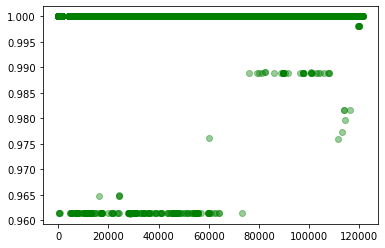

In [191]:
# Hago el gráfico de la primera serie:
fig = plt.figure()
# creo los axes
ax = plt.axes()
# dibujo en axes:
ax.scatter(dif_price_usd_per_m2_estimada.index, dif_price_usd_per_m2_estimada.values, marker = 'o', color = "green", label='serie sin', alpha = 0.4)

In [192]:
# Calculo la relación para la otra serie:
dif_price_per_m2_estimada = serie_price_per_m2_estimada / data["price_per_m2"].round(2)
dif_price_per_m2_estimada.min()

1.0

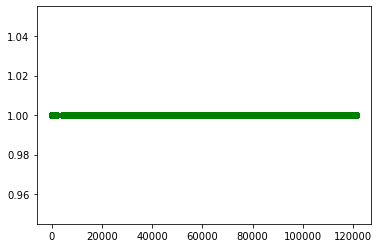

In [193]:
# Hago el gráfico de la segunda serie:
fig = plt.figure()
# creo los axes
ax = plt.axes()
# dibujo en axes:
ax.scatter(dif_price_per_m2_estimada.index, dif_price_per_m2_estimada.values, marker = 'o', color = "green", label='serie sin', alpha = 0.4)

Entonces:
- Para el caso de "price_per_m2": se divide la columna ""price", sin importar las unidades, con la columna "surface_covered_in_m2".
- Para el caso de "price_usd_per_m2": se divide la columna ""price", corregido por currency, con la columna "surface_total_in_m2".

Vamos a generar una nueva columna con los precios en dolares dividido la superficie total y los precios en dolares dividido la superficie cubierta. A diferencia de las originales, estas sí serán representativas: todas en dolares y teniendo en cuenta el tipo de superficie correcto, usando las nuevas columnas de datos.

In [194]:
data['precio_por_superficie_TOTAL'] = data['price_USD']/data['superficie_TOTAL']
data['precio_por_superficie_CUBIERTA'] = data['price_USD']/data['superficie_CUBIERTA']

Vemos con cuantos nulls y tamaño quedó nuestro DF

In [206]:
print(data.isnull().sum()/data.shape[0])
print(data.shape[0])

property_type                     0.000000
place_name                        0.000201
place_with_parent_names           0.000000
state_name                        0.000000
price                             0.149004
currency                          0.149004
price_aprox_local_currency        0.149004
price_aprox_usd                   0.149004
surface_total_in_m2               0.331141
surface_covered_in_m2             0.161868
price_usd_per_m2                  0.423553
price_per_m2                      0.260507
rooms                             0.603614
description                       0.000017
title                             0.000000
price_USD                         0.149004
superficie_TOTAL                  0.340665
superficie_CUBIERTA               0.171392
precio_por_superficie_TOTAL       0.429806
precio_por_superficie_CUBIERTA    0.268914
dtype: float64
114661


Veamos si hay registros con superficies definidas pero no con datos de precios y viceversa.

In [204]:
mask_prices = data.price_USD.isnull()
mask_surface_total = data.superficie_TOTAL.isnull()
mask_surface_cubierta = data.superficie_CUBIERTA.isnull()

print("Datos con precios pero sin superficie total: " + str(np.logical_and(np.logical_not(mask_prices),mask_surface_total).sum()))
print("Datos con precios pero sin superficie cubierta: " + str(np.logical_and(np.logical_not(mask_prices),mask_surface_cubierta).sum()))
print("Datos sin precios pero con superficie total: " + str(np.logical_and(np.logical_not(mask_surface_total),mask_prices).sum()))
print("Datos sin precios pero sin superficie cubierta: " + str(np.logical_and(np.logical_not(mask_surface_cubierta),mask_prices).sum()))
print("Datos SIN precios: " + str(mask_prices.sum()))

Datos con precios pero sin superficie total: 32197
Datos con precios pero sin superficie cubierta: 13749
Datos sin precios pero con superficie total: 10221
Datos sin precios pero sin superficie cubierta: 11182
Datos SIN precios: 17085


Elimino registros que NO tienen precio.

In [228]:
# Busco los índices:
mask_NaNs_prices = np.logical_and(np.logical_and(data.price.isnull(),data.currency.isnull()),np.logical_and(data.price_aprox_local_currency.isnull(),data.price_aprox_usd.isnull()))
print('Cantidad de elementos a eliminar:' + str(mask_NaNs_prices.sum()))
inds_prices = data.loc[mask_NaNs_prices].index
inds_prices

Cantidad de elementos a eliminar:17085


Int64Index([     5,     20,     41,     62,     67,     76,     83,     84,
                85,    100,
            ...
            121126, 121127, 121129, 121142, 121207, 121210, 121211, 121212,
            121213, 121214],
           dtype='int64', length=17085)

In [223]:
data_clean = data.drop(index = inds_prices)
                           
print(data.shape[0])
print(data_clean.shape[0])

114661
97576


Elimino registros que NO tienen NINGÚN dato de superficies (puede tener total o cubierta o los dos).

In [236]:
mask_NaNs_surfaces = np.logical_and(data_clean.superficie_TOTAL.isnull(),data_clean.superficie_CUBIERTA.isnull())
print('Cantidad de elementos a eliminar:' + str(mask_NaNs_surfaces.sum()))
inds_surfaces = data_clean.loc[mask_NaNs_surfaces].index
inds_surfaces

Cantidad de elementos a eliminar:8372


Int64Index([     1,      3,      9,     11,     65,     70,     71,     72,
                78,     88,
            ...
            120979, 121055, 121062, 121069, 121070, 121079, 121101, 121133,
            121134, 121144],
           dtype='int64', length=8372)

In [237]:
print("Antes de la limpieza: " + str(data_clean.shape[0]))

data_clean.drop(index = inds_surfaces, inplace = True)
                           
print("Después de la limpieza: " + str(data_clean.shape[0]))

Antes de la limpieza: 97576
Después de la limpieza: 89204


In [238]:
print(data.isnull().sum()/data.shape[0])
print(data.shape[0])

property_type                     0.000000
place_name                        0.000201
place_with_parent_names           0.000000
state_name                        0.000000
price                             0.149004
currency                          0.149004
price_aprox_local_currency        0.149004
price_aprox_usd                   0.149004
surface_total_in_m2               0.331141
surface_covered_in_m2             0.161868
price_usd_per_m2                  0.423553
price_per_m2                      0.260507
rooms                             0.603614
description                       0.000017
title                             0.000000
price_USD                         0.149004
superficie_TOTAL                  0.340665
superficie_CUBIERTA               0.171392
precio_por_superficie_TOTAL       0.429806
precio_por_superficie_CUBIERTA    0.268914
dtype: float64
114661


In [244]:
data_clean.state_name.value_counts()

Capital Federal                 27410
Bs.As. G.B.A. Zona Norte        22267
Bs.As. G.B.A. Zona Sur          10009
Buenos Aires Costa Atlántica     7762
Córdoba                          6714
Bs.As. G.B.A. Zona Oeste         6103
Santa Fe                         4960
Buenos Aires Interior            1498
Corrientes                        430
Mendoza                           423
Río Negro                         319
Neuquén                           262
Misiones                          252
Tucumán                           174
San Luis                          164
Chubut                            141
Entre Ríos                         99
Salta                              86
Tierra Del Fuego                   28
Chaco                              28
Catamarca                          22
La Pampa                           18
Santa Cruz                         12
Jujuy                              10
Formosa                             4
San Juan                            4
Santiago Del

## Veo si puedo sacar algo de description

Podemos ver si el precio de la descripción coincide con el precio de "price".
Por ejemplo: registro con id 74682:

In [197]:
data.iloc[74682]

property_type                                                   apartment
place_name                                                       Belgrano
place_with_parent_names              |Argentina|Capital Federal|Belgrano|
state_name                                                Capital Federal
price                                                              198000
currency                                                              USD
price_aprox_local_currency                                    3.49361e+06
price_aprox_usd                                                    198000
surface_total_in_m2                                                    52
surface_covered_in_m2                                                  45
price_usd_per_m2                                                  3807.69
price_per_m2                                                         4400
rooms                                                                 NaN
description                       BELG

In [198]:
mask_rare = np.logical_and(data.place_name == 'Temperley', data.surface_total_in_m2 == 370)
data.loc[mask_rare]

,property_type,place_name,place_with_parent_names,state_name,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,price_USD,superficie_TOTAL,superficie_CUBIERTA,precio_por_superficie_TOTAL,precio_por_superficie_CUBIERTA
74682,store,Temperley,|Argentina|Bs.As. G.B.A. Zona Sur|Lo...,Bs.As. G.B.A. Zona Sur,550000.0,USD,9704475.0,550000.0,370.0,490.0,1486.486486,1122.44898,NaN,Excelente local y Vivienda al fondo....,Local con Vivienda,550000.0,NaN,NaN,NaN,NaN


In [199]:
pd.options.display.max_colwidth = 1000
print(data.loc[mask_rare].description)
pd.options.display.max_colwidth = 40

74682    Excelente local y Vivienda al fondo. Local de 350m² con retiro de frente con deck de madera, acceso vidriado, recepción, amplio salón con barra, cocina con acceso de servicio y comunicación al salón, baño para discapacitados, amplio segundo salon c/barra, vip y acceso a patio trasero. PA: Antebaño mixto con bachas, 2 baños (Damas y Caballeros), duchas y depósito tipo altillo. Posee localización aprobada para FIESTAS INFANTILES, RESTAURANT, CAFETERIA, DECORACION, DISEÑO Y ROPA. Paredes con espejos y barras con piletas. Vivienda: (140m²) Acceso por pasillo, patio, living comedor c/piso porcelanato, AA y estufa de TB, cocina c/m/b/s/mesada y barra desayunadora, toilet de recepción. PA: Hall distribuidor c/placard, 2 dormitorios c/vestidor y piso flotante, uno en suite c/baño completo. 2ºPiso: Muy amplia terraza c/lavadero tipo quincho y sala de maquinas.También en Alquiler el Local solo en $40.000.-Tambien en venta con local lindero. U$D 670.000.-Para consultas telefónicas tenga 

In [200]:
data_ratings_nodup = data_ratings.drop_duplicates(subset = ["userId", "movieId"], keep = "first")

#6.b
movie_votes_count = data_ratings_nodup.groupby("movieId")["userId"].count()

#6.c
q1 = movie_votes_count.quantile(0.25)
print(q1)
q2 = movie_votes_count.quantile(0.5)
print(q2)
q3 = movie_votes_count.quantile(0.75)
print(q3)


iqr = (q3 - q1) * 1.5

up_threshold = q3 + iqr
low_threshold = q1 - iqr

print(up_threshold)
print(low_threshold)

#6.d
outlier_mask_up = movie_votes_count > up_threshold
outlier_mask_down = movie_votes_count < low_threshold
outlier_mask = np.logical_or(outlier_mask_up, outlier_mask_down)
not_outliers = np.logical_not(outlier_mask)

outliers = movie_votes_count[outlier_mask]

NameError: name 'data_ratings' is not defined